# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Подготовка данных

In [1]:
!pip install phik -q
!pip install -Uq scikit-learn

In [2]:
!pip install --upgrade scikit-learn imbalanced-learn category-encoders lightgbm

In [3]:
# импорт необходимых библиотек
import pandas as pd
import phik
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from fuzzywuzzy import fuzz
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, PolynomialFeatures, 
                                   StandardScaler, RobustScaler, MinMaxScaler, 
                                   Normalizer, MaxAbsScaler)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy.random import RandomState


RANDOM_STATE = 42

/opt/conda/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Загрузка данных

In [4]:
# считываем файл autos.csv и выводим первые пять строк на экран
autos = pd.read_csv('/datasets/autos.csv')
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# выводим общую информацию об autos
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Изучив общую информацию о файле, можем сказать, что всего в таблице 354369 строк и 16 столбцов. 

В столбцах *VehicleType*, *Gearbox*, *Model*, *FuelType*, *Repaired* есть пропуски.

Столбы *DateCrawled*, *DateCreated* и *LastSeen* имеют неверный тип данных *object*, так как это даты необходимо изменить тип данных на *timestamp*. 

Названия столбцов не соответствуют "хорошему" стилю.

### Предобработка данных

#### Переименование столбцов

In [6]:
# приведем названия столбцов к "хорошему" стилю
autos.columns = autos.columns.str.lower()
autos.rename(columns={'datecrawled': 'date_crawled', 
                      'vehicletype': 'vehicle_type',
                      'registrationyear': 'registration_year', 
                      'registrationmonth': 'registration_month',
                      'fueltype': 'fuel_type', 
                      'datecreated': 'date_created',
                      'numberofpictures': 'number_of_pictures', 
                      'postalcode': 'postal_code',
                      'lastseen': 'last_seen'}, inplace=True)
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Измениение типа данных

In [7]:
# изменим тип данных у стобцов с временем
autos['date_crawled'] = pd.to_datetime(autos['date_crawled'])
autos['date_created'] = pd.to_datetime(autos['date_created'])
autos['last_seen'] = pd.to_datetime(autos['last_seen'])
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

#### Работа с пропусками

In [8]:
# заполняем пропуски значением 'unknown'
# Заполняем пропуски значением 'unknown' только для столбцов типа 'object'
for col in autos.select_dtypes(include=['object']).columns:
    autos[col].fillna('unknown', inplace=True)
autos.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Учитывая, что пропуски присутствовали только в категориальных данных, было принято решение заполнить их значением 'unknown'. Замена пропусков на 'unknown' позволяет сохранить записи в датасете, которые могли бы быть потеряны при удалении строк с пропущенными значениями.

#### Поиск дубликатов

In [9]:
# проверяем датасет на дубликаты
autos.duplicated().sum()

4

In [10]:
# удаляем дубликаты
autos.drop_duplicates(inplace=True)
autos.duplicated().sum()

0

In [11]:
# выведем уникальные значения категориальных признаков
for col in autos.select_dtypes(include=['object']).columns:
    unique_values = autos[col].unique()
    print(f"Уникальные значения в столбце '{col}': {unique_values}")

Уникальные значения в столбце 'vehicle_type': ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
Уникальные значения в столбце 'gearbox': ['manual' 'auto' 'unknown']
Уникальные значения в столбце 'model': ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe'

Изучив уникальные названия категориальных признаков, можем сказать, что в столбце 'fuel_type' названия 'petrol' и 'gasoline' обозначают одно и тоже, необходимо их объединить. Так же в столбце 'model' очень много уникальных названий, необходимо проверить их на неполные дубликаты.

In [12]:
model_count = autos['model'].value_counts().index
model_count

Index(['golf', 'other', '3er', 'unknown', 'polo', 'corsa', 'astra', 'passat',
       'a4', 'c_klasse',
       ...
       'gl', 'samara', 'elefantino', 'kalina', 'i3', 'serie_2', 'rangerover',
       'serie_3', 'range_rover_evoque', 'serie_1'],
      dtype='object', length=251)

In [13]:
# создадим функцию для поиска опечатов в стобце моделей
def find_duplicates(data, threshold=85):
    # Преобразуем входные данные в Series
    if isinstance(data, pd.Index):
        series = data.to_series()
    elif not isinstance(data, pd.Series):
        series = pd.Series(data)
    else:
        series = data.copy()
    
    # Подготовка данных
    values = series.astype(str)
    n = len(values)
    duplicates = []
    
    # Поиск дубликатов с прогресс-баром для больших наборов данных
    for i in range(n):
        if any(i in (dup['index1'], dup['index2']) for dup in duplicates):
            continue
            
        for j in range(i+1, min(i+1000, n)):  # Ограничиваем окно сравнения
            similarity = fuzz.ratio(values[i], values[j])
            if similarity > threshold:
                duplicates.append({
                    'index1': i,
                    'index2': j,
                    'string1': values[i],
                    'string2': values[j],
                    'similarity': similarity
                })
    return duplicates
duplicates = find_duplicates(model_count, 90)
# Вывод результатов
print("Найденные дубликаты:")
for dup in duplicates:
    print(f"\nСтрока {dup['index1']}: '{dup['string1']}'")
    print(f"Строка {dup['index2']}: '{dup['string2']}'")
    print(f"Схожесть: {dup['similarity']}%")

Найденные дубликаты:

Строка 40: 'x_reihe'
Строка 56: 'mx_reihe'
Схожесть: 93%

Строка 40: 'x_reihe'
Строка 151: 'xc_reihe'
Схожесть: 93%

Строка 40: 'x_reihe'
Строка 189: 'rx_reihe'
Схожесть: 93%

Строка 40: 'x_reihe'
Строка 219: 'cx_reihe'
Схожесть: 93%

Строка 133: 'cr_reihe'
Строка 177: 'c_reihe'
Схожесть: 93%

Строка 217: 'range_rover'
Строка 247: 'rangerover'
Схожесть: 95%


Изучив все найденные дубликаты, можем сказать, что только 'range_rover' и 'rangerover' являются дубликатами, остальные модели - существующие модели разных брендов.

In [14]:
# замена значений в столбцах 'model' и 'fuel_type'
autos['model'] = autos['model'].replace('rangerover', 'range_rover')
autos['fuel_type'] = autos['fuel_type'].replace('gasoline', 'petrol')

#### Поиск аномалий

In [15]:
# сортировка столбца с годом регистрации
autos['registration_year'].sort_values()

66198     1000
183779    1000
323443    1000
174893    1000
97736     1000
          ... 
128677    9999
301279    9999
326725    9999
60079     9999
306578    9999
Name: registration_year, Length: 354365, dtype: int64

Так как 29 января 1886 года первый автомобиль в мире получил Германский Императорский патент, раньше этой даты быть зарегистрированным автомобиль не может и позже сегодняшнего дня тоже.

In [16]:
# удаление строк и годом регистрации раньше 1886 и позже 2025
autos = autos[(autos['registration_year'] >= 1886) & (autos['registration_year'] <= 2025)]
autos['registration_year'].sort_values()

77987     1910
78374     1910
29383     1910
218273    1910
223761    1910
          ... 
62809     2019
74469     2019
264473    2019
332451    2019
209501    2019
Name: registration_year, Length: 354194, dtype: int64

In [17]:
# преобразование столбцов 'registration_year' и 'registration_month' в строки
autos['registration_year'] = autos['registration_year'].astype(str)
autos['registration_month'] = autos['registration_month'].astype(str)

# замена '0' на '1' в registration_month
autos['registration_month'] = autos['registration_month'].replace('0', '1')

# добавление нуля в начале однозначных чисел в 'registration_monthregistration_month'
autos['registration_month'] = autos['registration_month'].apply(lambda x: x.zfill(2))

# преобразование 'registration_year' в datetime
autos = autos[(autos['registration_year'].astype(int) >= 1910) & (autos['registration_year'].astype(int) <= 2019)]

# создание нового столбца 'date_registration' путем объединения 'registration_year' и 'registration_month'
autos['date_registration'] = pd.to_datetime(autos['registration_year'] + '-' + autos['registration_month'] + '-01')
autos['date_registration']

0        1993-01-01
1        2011-05-01
2        2004-08-01
3        2001-06-01
4        2008-07-01
            ...    
354364   2005-07-01
354365   2005-01-01
354366   2000-03-01
354367   1996-03-01
354368   2002-06-01
Name: date_registration, Length: 354194, dtype: datetime64[ns]

Сравним дату регистрации автомобиля и дату скачивания анкеты на автомобиль из базы, аномалией будет, если дата регистрации автомобиля будет больше, чем дата скачивания анкеты из базы. Если такие аномалии есть, удалим их.

In [18]:
# вывод аномалии: дата регистрации автомобиля позже даты скачивания анкеты из базы
anom_crawled = autos[autos['date_registration'] >= autos['date_crawled']]
anom_crawled

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,date_registration
22,2016-03-23 14:52:51,2900,unknown,2018,manual,90,meriva,150000,05,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33,2018-05-01
26,2016-03-10 19:38:18,5555,unknown,2017,manual,125,c4,125000,04,unknown,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46,2017-04-01
31,2016-03-29 16:57:02,899,unknown,2016,manual,60,clio,150000,06,petrol,renault,unknown,2016-03-29,0,37075,2016-03-29 17:43:07,2016-06-01
35,2016-03-08 07:54:46,350,unknown,2016,manual,75,golf,150000,04,petrol,volkswagen,no,2016-03-08,0,19386,2016-03-08 09:44:50,2016-04-01
48,2016-03-25 14:40:12,7750,unknown,2017,manual,80,golf,100000,01,petrol,volkswagen,unknown,2016-03-25,0,48499,2016-03-31 21:47:44,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354198,2016-03-10 23:36:19,1350,unknown,2016,manual,0,clk,150000,08,unknown,mercedes_benz,yes,2016-03-10,0,26427,2016-03-13 02:45:51,2016-08-01
354203,2016-03-17 00:56:26,2140,unknown,2018,manual,80,fiesta,150000,06,unknown,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04,2018-06-01
354253,2016-03-25 09:37:59,1250,unknown,2018,unknown,0,corsa,150000,01,petrol,opel,unknown,2016-03-25,0,45527,2016-04-06 07:46:13,2018-01-01
354289,2016-03-05 14:55:29,5000,unknown,2017,manual,120,other,150000,07,unknown,citroen,yes,2016-03-05,0,15518,2016-04-05 11:48:09,2017-07-01


In [19]:
# удаление аномалий 
autos = autos[autos['date_registration'] <= autos['date_crawled']]
autos

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,date_registration
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,01,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57,1993-01-01
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,05,petrol,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2011-05-01
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,08,petrol,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46,2004-08-01
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,06,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2001-06-01
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,07,petrol,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,2008-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,unknown,2005,manual,0,colt,150000,07,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49,2005-07-01
354365,2016-03-14 17:48:27,2200,unknown,2005,unknown,0,unknown,20000,01,unknown,sonstige_autos,unknown,2016-03-14,0,39576,2016-04-06 00:46:52,2005-01-01
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,03,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12,2000-03-01
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,03,petrol,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26,1996-03-01


Так же сравним дату регистрации автомобиля и дату создания анкеты об автомобиле из базы, аномалией будет, если дата регистрации автомобиля будет больше, чем дата создания анкеты. Если такие аномалии есть, удалим их.

In [20]:
# вывод аномалии: дата регистрации автомобиля позже даты создания анкеты
anom_created = autos[(autos['date_registration'] > autos['date_created'])]
anom_created

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,date_registration
207119,2016-04-01 01:55:08,1100,unknown,2016,manual,105,golf,150000,04,unknown,volkswagen,yes,2016-03-31,0,76857,2016-04-05 01:18:13,2016-04-01


In [21]:
# удаление аномалий 
autos = autos[autos['date_registration'] <= autos['date_created']]
autos

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,date_registration
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,01,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57,1993-01-01
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,05,petrol,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2011-05-01
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,08,petrol,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46,2004-08-01
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,06,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2001-06-01
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,07,petrol,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,2008-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,unknown,2005,manual,0,colt,150000,07,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49,2005-07-01
354365,2016-03-14 17:48:27,2200,unknown,2005,unknown,0,unknown,20000,01,unknown,sonstige_autos,unknown,2016-03-14,0,39576,2016-04-06 00:46:52,2005-01-01
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,03,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12,2000-03-01
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,03,petrol,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26,1996-03-01


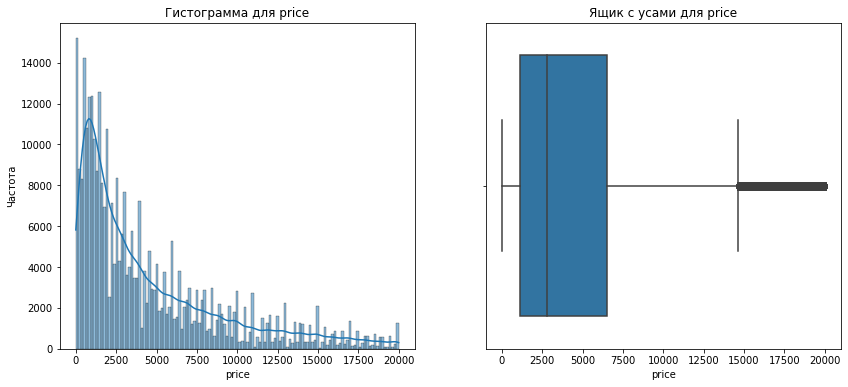

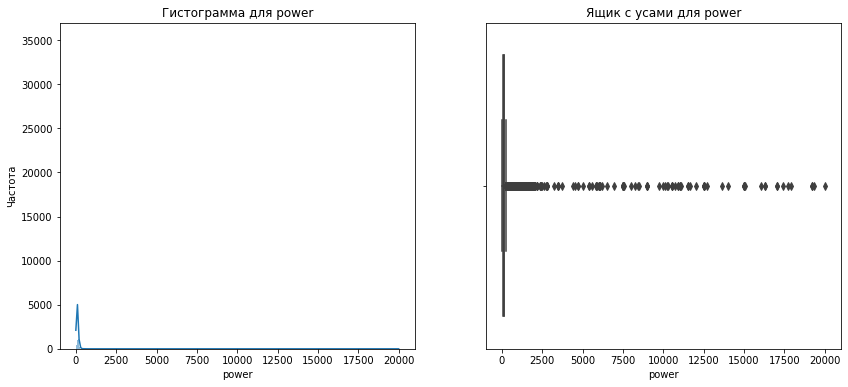

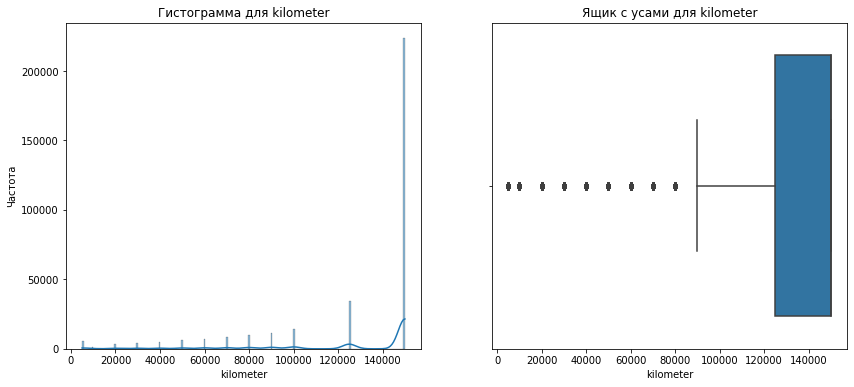

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


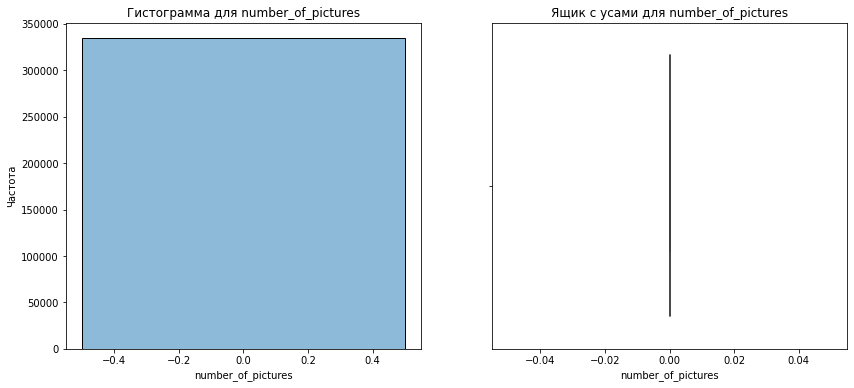

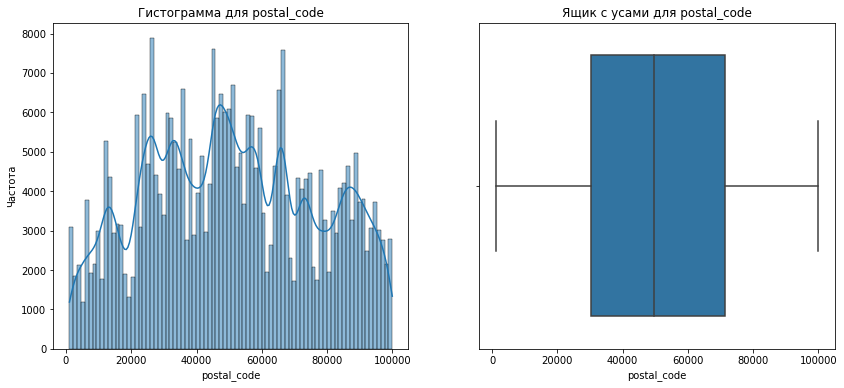

In [22]:
# создаем список с количественными непрерывными признаками
num_cols = ['price', 'power', 'kilometer', 'number_of_pictures', 'postal_code']

# для каждого признака строим гистограмму и ящик с усами
for col in num_cols:
    plt.figure(figsize=(14,6))

    plt.subplot(1, 2, 1)
    sns.histplot(autos[col], kde=True)
    plt.title(f'Гистограмма для {col}')
    plt.xlabel(col)  
    plt.ylabel('Частота')  

    plt.subplot(1, 2, 2)
    sns.boxplot(x=autos[col])
    plt.title(f'Ящик с усами для {col}')
    plt.xlabel(col)  


    plt.show()
    

По графикам видим, что цены автомобилей находятся в диапазоне от 0 до 20000, цены более 15000 являются выбросом. Есть автомобили, цена у которых 0, удалим их.

Графики по мощности автомобилей неинформативны, так как есть аномальные значения удалим значения, где можность больше 250.

Пробег меньше 90000 является выбросом.

В столбце number_of_pictures только нулевые значения, он не несет полезную информацию, удалим его.

В столбце с почтовым индексом владельца анкеты (пользователя) выбросов и аномалий нет, но в информации из этого столбца нет полезной информации, удалим его.

In [23]:
# удаление выбросов для значений столбца power и нулевой цены 
autos = autos[(autos['power'] < 2000) & (autos['power'] > 5)]
autos = autos[autos['price'] > 10]
autos

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,date_registration
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,05,petrol,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2011-05-01
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,08,petrol,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46,2004-08-01
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,06,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2001-06-01
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,07,petrol,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,2008-07-01
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07,1995-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354359,2016-03-28 13:48:07,7900,sedan,2010,manual,140,golf,150000,07,petrol,volkswagen,no,2016-03-28,0,75223,2016-04-02 18:16:20,2010-07-01
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,05,petrol,seat,yes,2016-03-19,0,96465,2016-03-19 20:44:43,2004-05-01
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,03,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12,2000-03-01
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,03,petrol,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26,1996-03-01


#### Создание и удаление признаков

In [24]:
# объеденим признаки brand и model
autos['brand_model'] = autos['brand'] + '_' + autos['model']
autos['brand_model'].value_counts().index

Index(['volkswagen_golf', 'bmw_3er', 'volkswagen_polo', 'opel_corsa',
       'opel_astra', 'audi_a4', 'volkswagen_passat', 'mercedes_benz_c_klasse',
       'bmw_5er', 'mercedes_benz_e_klasse',
       ...
       'bmw_i3', 'lada_samara', 'lada_kalina', 'land_rover_serie_2',
       'land_rover_serie_3', 'rover_discovery',
       'land_rover_range_rover_evoque', 'rover_range_rover',
       'rover_freelander', 'rover_defender'],
      dtype='object', length=336)

In [25]:
# создадим новый признак возраст машины в месяцах на момент выгрузки анкеты из базы
autos['age_month'] = (autos['date_crawled'] - autos['date_registration']).dt.days / 30.44
autos['age_month']

1          58.771353
2         139.388962
3         177.496715
4          92.969777
5         246.090670
             ...    
354359     68.889619
354362    142.575558
354366    192.115637
354367    240.571616
354368    165.604468
Name: age_month, Length: 292183, dtype: float64

In [26]:

# удаление не нужных признаков
autos = autos.drop(columns=['date_crawled', 'registration_year', 'model', 'registration_month', 'brand', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'date_registration'])
autos

,price,vehicle_type,gearbox,power,kilometer,fuel_type,repaired,brand_model,age_month
1,18300,coupe,manual,190,125000,petrol,yes,audi_unknown,58.771353
2,9800,suv,auto,163,125000,petrol,unknown,jeep_grand,139.388962
3,1500,small,manual,75,150000,petrol,no,volkswagen_golf,177.496715
4,3600,small,manual,69,90000,petrol,no,skoda_fabia,92.969777
5,650,sedan,manual,102,150000,petrol,yes,bmw_3er,246.090670
...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,manual,140,150000,petrol,no,volkswagen_golf,68.889619
354362,3200,sedan,manual,225,150000,petrol,yes,seat_leon,142.575558
354366,1199,convertible,auto,101,125000,petrol,no,smart_fortwo,192.115637
354367,9200,bus,manual,102,150000,petrol,no,volkswagen_transporter,240.571616


### Корреляционный анализ

Выполним корреляционный анализ данных. Изучим взаимосвязь между всеми признаками, вычислим коэффициенты корреляции Phik между всеми признаками, так как не все признаки распределены нормально, и построим тепловую карту по полученной таблице для наглядности.

In [27]:
corr = autos.phik_matrix(interval_cols=['price','power','kilometer', 'age_month'])
corr

,price,vehicle_type,gearbox,power,kilometer,fuel_type,repaired,brand_model,age_month
price,1.000000,0.272555,0.292661,0.337438,0.314034,0.103093,0.335634,0.586118,0.607579
vehicle_type,0.272555,1.000000,0.392393,0.177204,0.250607,0.222731,0.316476,0.909809,0.163106
gearbox,0.292661,0.392393,1.000000,0.373249,0.057549,0.144253,0.265327,0.650469,0.087801
power,0.337438,0.177204,0.373249,1.000000,0.041348,0.063388,0.056874,0.517854,0.112419
kilometer,0.314034,0.250607,0.057549,0.041348,1.000000,0.076648,0.225922,0.459254,0.323529
fuel_type,0.103093,0.222731,0.144253,0.063388,0.076648,1.000000,0.178863,0.437260,0.076237
repaired,0.335634,0.316476,0.265327,0.056874,0.225922,0.178863,1.000000,0.287487,0.204049
brand_model,0.586118,0.909809,0.650469,0.517854,0.459254,0.437260,0.287487,1.000000,0.633812
age_month,0.607579,0.163106,0.087801,0.112419,0.323529,0.076237,0.204049,0.633812,1.000000


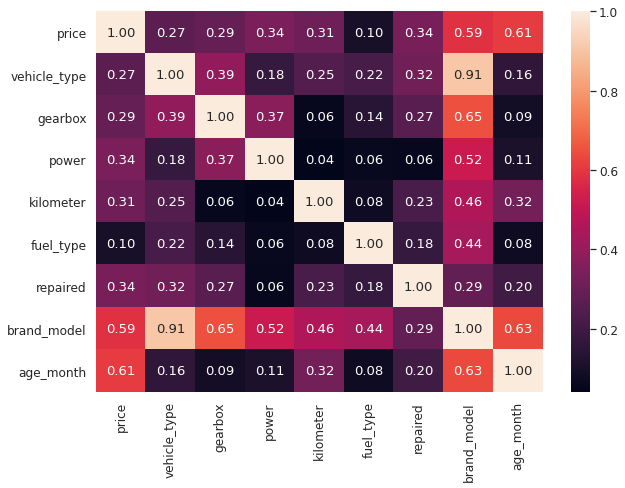

In [28]:
# построим тепловую карту коэффициентов phik
sns.set(font_scale=1.1)
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f') 
plt.show()

Анализируя тепловую карту, можем сказать:

**Сильная связь**:

    - между мощностью и маркой автомобиля - 0,8
    
**Заметная связь**:

    - между ценой и возрастом автомобиля - 0,61
    - между ценой и маркой автомобиля - 0,58
    - между типом автомобильного кузова и типом коробки передач - 0,55
    - между типом автомобильного кузова и мощностью автомобиля - 0,52
    - между типом коробки передач и мощностью автомобиля - 0,57
    - между типом коробки передач и маркой автомобиля - 0,63
    - между маркой и возрастом машины - 0,64
    
**Умеренная связь**:

    - между ценой и мощностью - 0,49
    - между типом автомобильного кузова и была ли машина в ремонте - 0,43
    - между типом коробки передач и была ли машина в ремонте - 0,46
    - между пробегом и маркой автомобиля - 0,46
    - между типом топлива и маркой автомобиля - 0,44
    - между была ли машина в ремонте и датой регистрации  - 0,47

Так же мы можем сказать о **мультиколлинеарности** между типом автомобильного кузова и маркой машины, коэффициент phik равен 0,9.


Между остальными признаками связь либо слабая либо отсутствует вовсе.

Т.е. цена в основном зависит от возраста, марки и мощности автомобиля.

### Подготовка данных

In [29]:
# создание входных и целевого признаков
X = autos.drop('price', axis=1)
y = autos['price']

# разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.25,
    random_state=RANDOM_STATE)

In [30]:
# создаём списки с названиями признаков
num_columns = ['power','kilometer', 'age_month'] 
cat_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand_model']
# преобразуем категориальные столбцы в тип 'category'
autos[cat_columns] = autos[cat_columns].astype('category')

# пайплайн для категориальных признаков
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist',
        min_frequency=0.05,
        sparse_output=False))
])

# пайплайн для количественных признаков 
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()) 
])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
   transformers=[
       ('cat', cat_pipe, cat_columns),
       ('num', num_pipe, num_columns) ],
    remainder='passthrough'
)

data_preprocessor_lbg = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_columns),
        ('cat', cat_pipe, cat_columns)
    ],
    remainder='passthrough')

data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.05,
                                                                sparse_output=False))]),
                                 ['vehicle_type', 'gearbox', 'fuel_type',
                                  'repaired', 'brand_model']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['power', 'kilometer', 'age_month'])])

## Обучение моделей

### Модель линейная регрессия

In [32]:
# cоздание пайплайна с препроцессором и моделью LinearRegression
model_lr  = Pipeline(steps=[
    ('data_preprocessor', data_preprocessor),
    ('scaler', 'passthrough'),
    ('regressor', LinearRegression())
])

# oпределение параметров для оптимизации LinearRegression
param_grid_lr = {
    'scaler': [StandardScaler(with_mean=False), RobustScaler(with_centering=False), MaxAbsScaler(), Normalizer(), 'passthrough'],
    'regressor__fit_intercept': [True, False],
    'regressor__n_jobs': [-1, 1]
}
# Создание объекта GridSearchCV для LinearRegression
grid_search_lr = GridSearchCV(
    model_lr,
    param_grid_lr,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

grid_search_lr.fit(X_train, y_train)

# вывод лучших параметров для LinearRegression
print("Лучшие параметры для LinearRegression: ", grid_search_lr.best_params_)

# вывод лучшей метрики на кросс-валидации для LinearRegression
print("Лучшая метрика на кросс-валидации для LinearRegression: ", grid_search_lr.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories

Лучшие параметры для LinearRegression:  {'regressor__fit_intercept': True, 'regressor__n_jobs': -1, 'scaler': Normalizer()}
Лучшая метрика на кросс-валидации для LinearRegression:  -2409.5366591212796


In [33]:
best_model_lr = grid_search_lr.best_estimator_
best_model_lr

Pipeline(steps=[('data_preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'repaired',
                                                   'brand_model']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['power', 'kilometer',
                                                   'age_month'])])),
                ('scaler', Normalizer()),
                ('regressor', LinearRegression(n_jobs=-1))])

### Модель градиентного бустинга с использованием LightGBM

In [38]:
# создание пайплайна с препроцессором и моделью LGBMRegressor
model_lgb = Pipeline(steps=[
    ('data_preprocessor', data_preprocessor_lbg),
    ('scaler', StandardScaler()),
    ('regressor', LGBMRegressor(verbose=-1, 
                                boosting_type='gbdt', 
                                objective='regression', 
                                random_state=RANDOM_STATE))
])

# определение параметров для оптимизации LGBMRegressor
param_grid_lgb = {
    'scaler': [StandardScaler(), RobustScaler(), MinMaxScaler(), 'passthrough'],
    'regressor__learning_rate': [0.05, 0.01],
    'regressor__min_child_samples': [10, 20],  # Добавлен важный параметр
    'regressor__reg_alpha': [0, 0.1]  # Добавлена L1-регуляризация
}

# создание объекта GridSearchCV для LGBMRegressor
grid_search_lgb = GridSearchCV(
    model_lgb,
    param_grid_lgb,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

# запуск оптимизации для LGBMRegressor
grid_search_lgb.fit(X_train, y_train)

# вывод лучших параметров для LGBMRegressor
print("Лучшие параметры для LGBMRegressor: ", grid_search_lgb.best_params_)

# вывод лучшей метрики на кросс-валидации для LGBMRegressor
print("Лучшая метрика на кросс-валидации для LGBMRegressor: ", grid_search_lgb.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be

Лучшие параметры для LGBMRegressor:  {'regressor__learning_rate': 0.05, 'regressor__min_child_samples': 10, 'regressor__reg_alpha': 0.1, 'scaler': 'passthrough'}
Лучшая метрика на кросс-валидации для LGBMRegressor:  -1936.6421259979797


In [39]:
best_model_lgb = grid_search_lgb.best_estimator_
best_model_lgb

Pipeline(steps=[('data_preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['power', 'kilometer',
                                                   'age_month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'repaired',
                                                   'brand_model'])])),
                ('scaler', 'passthrough'),
                ('regressor',
                 LGBMRegressor(learning_rate=0.05, min_child_samples=10,
                               objective='regression', random_state=42,
                               reg_alpha=0.1, verbose=-1))])

При сравнении моделей LinearRegression и LGBMRegressor, модель LGBMRegressor показывает лучшую метрику на кросс-валидации - 1937, тогда как у модели LinearRegression эта метрика -2409. Так же модель LGBMRegressor может оказаться более подходящим выбором, особенно если в данных присутствуют сложные нелинейные зависимости, которые LinearRegression не может уловить.

## Анализ моделей

In [40]:
# время обучения линейной модели
start_time = time.time()
best_model_lr.fit(X_train, y_train)
lr_training_time = time.time() - start_time
print(f"Время обучения линейной модели: {lr_training_time} секунд")

# время предсказания линейной модели
start_time = time.time()
lr_predictions = best_model_lr.predict(X_train)
lr_prediction_time = time.time() - start_time
lr_prediction_time
print(f"Время предсказания линейной модели: {lr_prediction_time} секунд")

Время обучения линейной модели: 2.254504919052124 секунд
Время предсказания линейной модели: 0.6861743927001953 секунд


In [41]:
# время обучения LGBMRegressor
start_time = time.time()
best_model_lgb.fit(X_train, y_train)
lgb_training_time = time.time() - start_time
lgb_training_time
print(f"Время обучения LightGBM модели: {lgb_training_time} секунд")

# время предсказания LGBMRegressor
start_time = time.time()
lgb_predictions = best_model_lgb.predict(X_train)
lgb_prediction_time = time.time() - start_time
lgb_prediction_time
print(f"Время предсказания LightGBM модели: {lgb_prediction_time} секунд")

Время обучения LightGBM модели: 4.421981573104858 секунд


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Время предсказания LightGBM модели: 2.019045352935791 секунд


Время обучения и предсказания LGBMRegressor сильно больше, время обучения 4,42 секунды, при этом у  линейной модели - 2,25, время предсказания у модели LightGBM - 2,02, в то время как у LinearRegression - 0,69 секунды. RMSE линейной модели равен 2409, RMSE модели LightGBM равен 1937. Исходя из того, что метрика все же лучше у LightGBM модели, для нас она является лучшей моделью. Но если для нас сильно важны время, следовало бы выбрать линейную модель.

In [ ]:
# применение лучшей модели к тестовым данным
lgb_test_predictions = best_model_lgb.predict(X_test)

# вычисление RMSE и средней ошибки для модели LightGBM на тестовых данных
lgb_test_rmse = np.sqrt(mean_squared_error(y_test, lgb_test_predictions))

print(f"RMSE модели LightGBM на тестовых данных: {lgb_test_rmse}")


In [ ]:
# получаем имена преобразованных признаков
transformed_features = best_model_lgb.named_steps['data_preprocessor'].get_feature_names_out()

# получаем важность признаков из LGBM
lgb_regressor = best_model_lgb.named_steps['regressor']
importances = lgb_regressor.feature_importances_

# создаём DataFrame с правильными именами признаков
feature_importance = pd.DataFrame({
    'feature': transformed_features,
    'importance': importances
}).sort_values('importance', ascending=False)

# выводим топ-10 важных признаков
print(feature_importance.head(20))

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.show()

На графике видно, что самый важный признак - это мощность автомобиля, на втором месте по важности - возраст машины, следующий по важности признак, влияющий на цену - это совокупность пробега и возраста машины.

## Общий вывод

Для разработки приложения по расчету рыночной стоимости автомобилей была проведена огромная работа по подготовке и анализу данных. Была проведена предобработка данных, выявлены и удалены дубликаты, выявлены некорректные типы данных и заменены на корректные, найдены и удалены аномалии в данных, была проведена работа с пропусками в данных, а так же добавлены необходимые для обучения моделей признаки и удалены неиформативные.

Был проведен исследовательский анализ данных и корреляционный анализ.

Затем была проведена подготовка данных к обучению. 

Для обучения были выбраны 2 модели: линейная модель и модель градиентного бустинга с использованием LightGBM.

После сравнения моделей можно сказать, что модель LightGBM показала лучшее значение метрики RMSE, так же у этой моделе меньше время обучения, однако почти в 2 раза больше время предсказания. Можем сказать, что требование проекта было выполнено, обе модели показали RMSE ниже установленного порога в 2500. 

Для достижения наилучшего баланса между качеством предсказаний и временем обучения и предсказания, LGBMRegressor может потребовать дополнительной настройки гиперпараметров.
